## Setup and Imports 

In [63]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Import our custom data access client
# Restart imports to pick up new methods
import importlib
import src.aqf.data_access
import src.aqf.tickers
importlib.reload(src.aqf.data_access)
importlib.reload(src.aqf.tickers)
from src.aqf.data_access import FirstRateDataClient
from src.aqf.tickers import NASDAQ_TICKERS

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
warnings.filterwarnings('ignore')

# Configure matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

# Configure plotly
import plotly.io as pio
pio.renderers.default = 'notebook'


## Initialize Data Client 

In [64]:
# Initialize the FirstRateData client
client = FirstRateDataClient(profile_name="firstratedata")

# Get overview of available data
print("\nData Availability Overview:")
dates_info = client.get_available_dates()
for key, value in dates_info.items():
    print(f"   {key}: {value}")

FirstRateData client initialized

Data Availability Overview:
   years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
   latest_year: 2024
   latest_year_months: [1, 2, 3, 4, 5, 6, 7, 8]
   date_range: 2000-2024


## Multi-Ticker Neural Network Data Preparation

In [65]:
start_date = '2024-01-02'
end_date = '2024-01-10' 

print(f"\nLoading {len(NASDAQ_TICKERS)} tickers from {start_date} to {end_date} ...")

try:
    multi_ticker_data = client.load_multi_ticker_data(
        tickers=NASDAQ_TICKERS,
        start_date=start_date,
        end_date=end_date,
        frequency='15T',  
        add_features=True
    )
    
    print(f"Successfully loaded data!")
    
    # Display sample data
    print(f"\nSample data (first 5 rows):")
    print(multi_ticker_data.head())
    
except Exception as e:
    print(f"Error loading multi-ticker data: {e}")
    import traceback
    traceback.print_exc()


Loading 19 tickers from 2024-01-02 to 2024-01-10 ...
Loading data from 2024-01-02 to 2024-01-10
Loaded 1,270,901 records for 2024-01-02
Loaded 1,265,947 records for 2024-01-03
Loaded 1,213,893 records for 2024-01-04
Loaded 1,212,962 records for 2024-01-05
No data found for 2024-01-06
No data found for 2024-01-07
Loaded 1,221,931 records for 2024-01-08
Loaded 1,198,763 records for 2024-01-09
Loaded 1,188,361 records for 2024-01-10
Found tickers: ['NFLX', 'META', 'AVGO', 'TXN', 'TSLA', 'AMGN', 'AMZN', 'AAPL', 'ADBE', 'CSCO', 'MSFT', 'GOOGL', 'CMCSA', 'INTC', 'COST', 'QCOM', 'NVDA', 'PEP', 'PYPL']
Creating trading-only time index with 189 timestamps (weekends excluded)
   Processing NFLX...
      NFLX: 189 samples (filled 0 NaNs)
   Processing META...
      META: 189 samples (filled 0 NaNs)
   Processing AVGO...
      AVGO: 189 samples (filled 0 NaNs)
   Processing TXN...
      TXN: 189 samples (filled 0 NaNs)
   Processing TSLA...
      TSLA: 189 samples (filled 0 NaNs)
   Processing AM

Creating aligned dataset from close column...
   No missing values
Successfully created aligned dataset!
   Missing values per ticker:
      AAPL: 0 (0.0%)
      ADBE: 0 (0.0%)
      AMGN: 0 (0.0%)
      AMZN: 0 (0.0%)
      AVGO: 0 (0.0%)
      CMCSA: 0 (0.0%)
      COST: 0 (0.0%)
      CSCO: 0 (0.0%)
      GOOGL: 0 (0.0%)
      INTC: 0 (0.0%)
      META: 0 (0.0%)
      MSFT: 0 (0.0%)
      NFLX: 0 (0.0%)
      NVDA: 0 (0.0%)
      PEP: 0 (0.0%)
      PYPL: 0 (0.0%)
      QCOM: 0 (0.0%)
      TSLA: 0 (0.0%)
      TXN: 0 (0.0%)

Sample aligned data (first 5 rows):
ticker                         AAPL     ADBE      AMGN      AMZN      AVGO  \
timestamp                                                                    
2024-01-02 09:30:00-05:00  185.5559  583.470  285.9421  150.1000  108.8316   
2024-01-02 09:45:00-05:00  185.8149  583.880  289.8167  149.3000  109.0181   
2024-01-02 10:00:00-05:00  185.8249  580.940  290.8761  149.2200  108.9570   
2024-01-02 10:15:00-05:00  185.4860  58

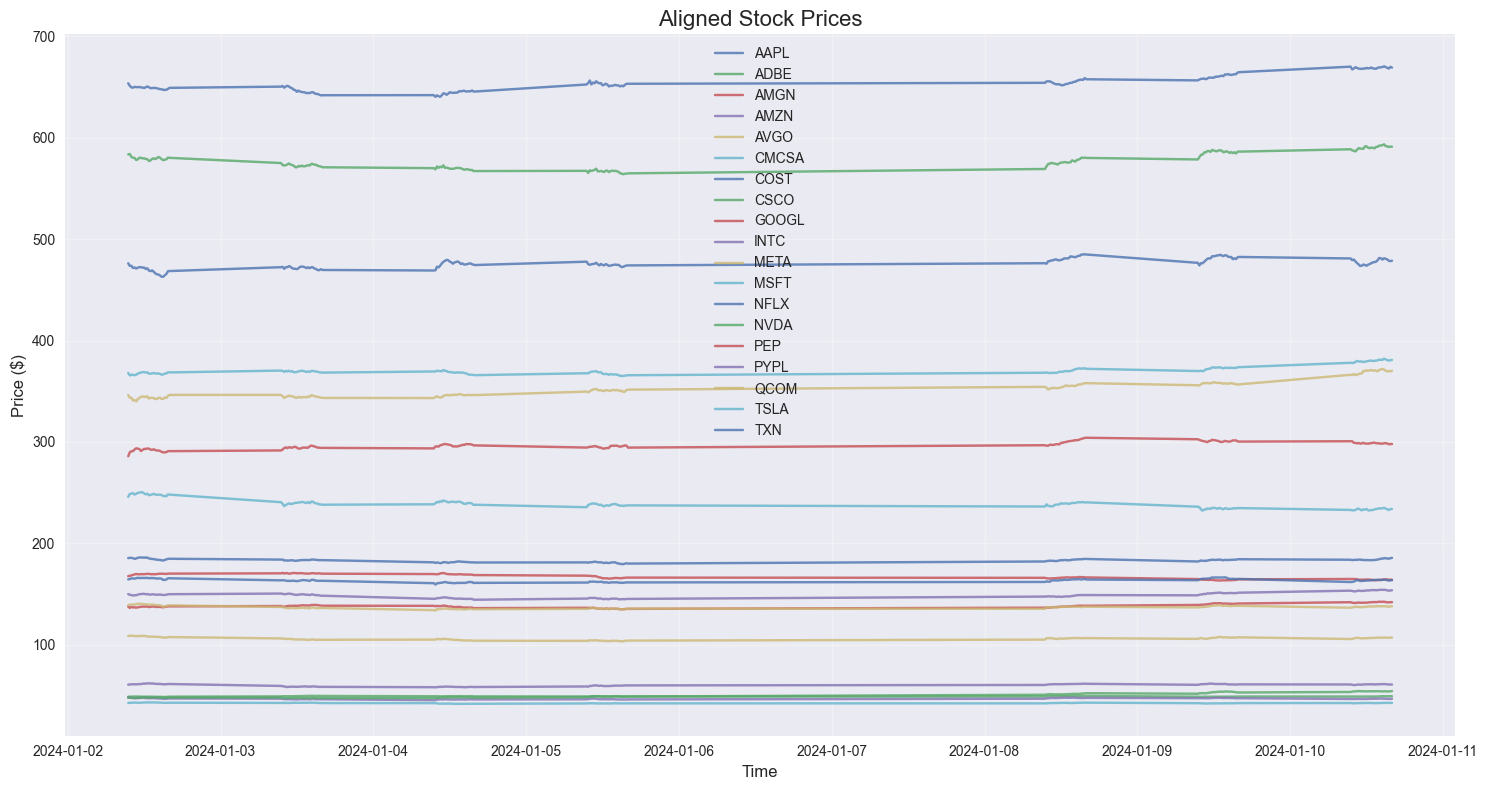

In [67]:
if 'multi_ticker_data' in locals() and not multi_ticker_data.empty:
    try:
        # Create aligned dataset (tickers as columns)
        aligned_data = client.create_aligned_dataset(
            multi_ticker_data, 
            value_column='close',  # Use close prices
            fill_method='forward'
        )
        
        print(f"Successfully created aligned dataset!")
        print(f"   Missing values per ticker:")
        for col in aligned_data.columns:
            missing = aligned_data[col].isna().sum()
            print(f"      {col}: {missing} ({missing/len(aligned_data)*100:.1f}%)")
        
        # Display sample aligned data
        print(f"\nSample aligned data (first 5 rows):")
        print(aligned_data.head())
        
        # Plot aligned data
        fig, ax = plt.subplots(figsize=(15, 8))
        for ticker in aligned_data.columns:
            ax.plot(aligned_data.index, aligned_data[ticker], label=ticker, alpha=0.8)
        
        ax.set_title('Aligned Stock Prices', fontsize=16)
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel('Price ($)', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating aligned dataset: {e}")
        import traceback
        traceback.print_exc()
else:
    print("No multi-ticker data available to create aligned dataset.")